<img src="Images/LL3-backdrop.png">

### Dates/Deadlines

Code: <i>29/04/2019 (one week before submission)</i><br />
Report: <i>05/05/2019 (20:00)</i><br />

### Imports

 You'll need to install the following libraries:
 * Gym
 * Box2D
  * brew install swig
  * pip install box2d-py
  * pip install box2d


### Questions

 * Should we do [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2/) or [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/)?


### Comments
 
 * I think we should start with the discrete [LunarLander](https://gym.openai.com/envs/LunarLander-v2/) first then if we have the time attempt the continous one.
 
### Report

The project report should describe the problem you address, present your approach (or
approaches, if you experimented with more than one approach), and evaluate how well you have
solved the problem. It should also discuss alternative solution methods that are applicable, along
with the relative merits of your approach. Finally, the report should describe your personal
experience with the project, for example, the difficulties or any pleasant surprises you have
encountered along the way. Do not explain material that has been discussed in the lectures. For
example, there is no need to explain Q-learning or function approximation. 

Page limit: 8

### TO-DO

 * Create the agent
 * Save videos after $n$ iterations
 * Look into including the Neural Network like Mar.io (not important) 
 * We need to think of some "alternative solution" to this problem

 
### Links

 * [GitHub](https://github.bath.ac.uk/jwm59/RL-Robotics-Project)
 * [Trouble install Box2D - helped me](https://github.com/openai/gym/issues/100)
 * [More trouble shooting with Box2D](http://www.jtdz-solenoids.com/stackoverflow_/questions/44198228/install-pybox2d-for-python-3-6-with-conda-4-3-21)


In [1]:
#Importing
import gym
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

from IPython.display import clear_output, display #Not sure what this is doing exactly

import Box2D #Not sure we need this, check later


#####
import gym
import numpy as np
from IPython.display import clear_output, display
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
import copy
import matplotlib.pyplot as plt


Using TensorFlow backend.


### Setting up the gym environment

## LunarLander-v2

* Observation Space: 8
 * X
 * Y
 * X velocity
 * Y velocity
 * Self angle
 * Angular velocity
 * Left leg contact 
 * Right lef contact
* Action Space: 4
 * Do nothing
 * Fire left orientation engine
 * Fire right orientation engine
 * Fire main engine


## LunarLanderContinuous-v2

* Observation Space: 8
 * X
 * Y
 * X velocity
 * Y velocity
 * Self angle
 * Angular velocity
 * Left leg contact 
 * Right lef contact
* Action Space: two real values vector from -1 to +1
 * First controls main engine, -1..0 off, 0..+1 throttle from 50% to 100% power
 * Second value -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off


In [2]:
env_discrete = gym.make('LunarLander-v2')
env_continuous = gym.make('LunarLanderContinuous-v2')

# Deep Q-learning

### Approach

"Probably should explain the approach we plan to take..."

In [3]:
## Creating Deep-Q network
def q_network(numInput, numHidden, numHiddenLayers, numOutput, optimiserFunction=tf.train.AdamOptimizer, \
              alpha=0.001, lossFunction="mse", hiddenActivation="relu", outputActivation="linear"): 
    
    #Creating a TensorFlow class
    network = Sequential()
    
    #Creating first hidden layer
    network.add(Dense(numHidden, input_dim=numInput, activation=hiddenActivation))
    
    #Adding 'n' hidden layers
    for _ in range(numHiddenLayers):
        network.add(Dense(numHidden, activation=hiddenActivation))
        
    #Creating output layer
    network.add(Dense(numOutput, activation=outputActivation))
    
    #Defining the loss function, the optimiser and the metrics.
    network.compile(loss=lossFunction, optimizer=Adam(lr=alpha))
    
    return network
    '''
    q_network = Sequential()
    q_network.add(Dense(10, input_dim=numObservation, activation='relu'))
    q_network.add(Dense(10, activation='relu'))
    q_network.add(Dense(numActions, activation='linear'))
    q_network.compile(loss='mse', optimizer=Adam(lr=0.001))
    
    return(q_network)
    '''
    
   

In [4]:
### Full agent class. Look back on the w
class rocketMan():
    def __init__(self, environment, numObservations, numActions, numHidden, numHiddenLayer, modelFileName, \
                     gamma=0.99, alpha=0.001, epsilon=1, epsilonDecay=0.98, epsilon_min=0, tau=0.95, \
                     load=False, save=True):

        self.numObservations = numObservations
        self.numActions = numActions
        self.numHidden = numHidden
        self.numHiddenLayer = numHiddenLayer
        
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.tau = tau
        
        self.epsilon = epsilon
        self.epsilonDecay = epsilonDecay
        self.epsilon_min = epsilon_min
        
        #replay buffer
        self.replay_buffer = []
        
        # The networks
        self.q_network = q_network(self.numObservations,self.numHidden,self.numHiddenLayer,self.numActions)
        self.q_target_network = q_network(self.numObservations,self.numHidden,self.numHiddenLayer,self.numActions)
                
        if(load):
            self.q_network.load_weights(modelFileName)
      
    
        self.soft_target_weight_update(1)
    
    def updateEpsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilonDecay
        
        if(self.epsilon < self.epsilon_min):
            self.epsilon = self.epsilon_min
    
    def select_epsilon_greedy_action(self, state):            
        if np.random.uniform(0, 1) < self.epsilon:
            return(env.action_space.sample())  # random action
        else:
            q_values = self.q_network.predict(state)
            return(np.argmax(q_values[0]))        # greedy action

    def soft_target_weight_update(self, tau):
        # Q network weights
        weights = np.asarray(self.q_network.get_weights())
        
        # Target network weights
        target_weights = np.asarray(self.q_target_network.get_weights())
        
        # 
        self.q_target_network.set_weights( (weights * tau) + (target_weights * (1 - tau)))

    def learn_from_transition(self, action, state,next_state, reward, done):
        q_values = self.q_network.predict(state)

        target_q_values = q_values
        
        if done == True: 
            target_q_values[0][action] = reward
        else: 
            target_q_values[0][action] = reward + (self.gamma * np.max(self.q_target_network.predict(next_state)) )
        
        self.q_network.fit(state, target_q_values, epochs=8, batch_size=32, verbose=0)

    def learn_from_m_random_transitions_in_replay_buffer(self, m = 1):
        
        assert m >= 1
        
        size_of_replay_buffer = len(self.replay_buffer)
        for i in range(m):                          # m is number of transitions
            transition_index = random.randint(0, size_of_replay_buffer-1)
            action, state, next_state, reward, done_bool = self.replay_buffer[transition_index]
            self.learn_from_transition(action, state, next_state, reward, done_bool)
        self.soft_target_weight_update(0.5)
        
        
    def add_to_replay_buffer(self, action, current_state, next_state, reward, done): 
        transition_tuple = (action, current_state, next_state, reward, done)
        self.replay_buffer.append(transition_tuple)

In [5]:
### Full agent class. Look back on the w
class rocketMan_V2():
    def __init__(self, environment, numObservations, numActions, numHidden, numHiddenLayer, modelFileName, \
                     gamma=0.99, alpha=0.001, epsilon=1, epsilonDecay=0.98, epsilon_min=0, tau=0.95, \
                     load=False, save=True):

        self.numObservations = numObservations
        self.numActions = numActions
        self.numHidden = numHidden
        self.numHiddenLayer = numHiddenLayer
        
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.tau = tau
        
        self.epsilon = epsilon
        self.epsilonDecay = epsilonDecay
        self.epsilon_min = epsilon_min
        
        #replay buffer
        self.replay_buffer = []
        
        # The networks
        self.q_network = q_network(self.numObservations,self.numHidden,self.numHiddenLayer,self.numActions)
        self.q_target_network = q_network(self.numObservations,self.numHidden,self.numHiddenLayer,self.numActions)
                
        if(load):
            self.q_network.load_weights(modelFileName)
      
    
        self.soft_target_weight_update(1)
    
    def updateEpsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilonDecay
        
        if(self.epsilon < self.epsilon_min):
            self.epsilon = self.epsilon_min
    
    def select_epsilon_greedy_action(self, state):            
        if np.random.uniform(0, 1) < self.epsilon:
            return(env.action_space.sample())  # random action
        else:
            q_values = self.q_network.predict(state)
            return(np.argmax(q_values[0]))        # greedy action

    def soft_target_weight_update(self, tau):
        # Q network weights
        weights = np.asarray(self.q_network.get_weights())
        
        # Target network weights
        target_weights = np.asarray(self.q_target_network.get_weights())
        
        # 
        self.q_target_network.set_weights( (weights * tau) + (target_weights * (1 - tau)))

    def learn_from_transition(self, action, state,next_state, reward, done):
        q_values = self.q_network.predict(state)

        target_q_values = q_values
        
        if done == True: 
            target_q_values[0][action] = reward
        else: 
            target_q_values[0][action] = reward + (self.gamma * np.max(self.q_target_network.predict(next_state)) )
        
        self.q_network.fit(state, target_q_values, epochs=8, batch_size=32, verbose=0)

    def learn_from_m_random_transitions_in_replay_buffer(self, m = 1):
        
        assert m >= 1
        
        size_of_replay_buffer = len(self.replay_buffer)
        
        sortTest = sorted(self.replay_buffer, reverse = True, key=lambda tup: tup[3])
        
        #for _ in range(m):                          # m is number of transitions
        #    transition_index = random.randint(0, size_of_replay_buffer-1)
        for transition_index in range(len(sortTest)):
            if(transition_index > np.sqrt(len(sortTest))):
                break
            action, state, next_state, reward, done_bool = self.replay_buffer[transition_index]
            self.learn_from_transition(action, state, next_state, reward, done_bool)
            
            action, state, next_state, reward, done_bool = self.replay_buffer[-(transition_index+1)]
            self.learn_from_transition(action, state, next_state, reward, done_bool)
            
        #Learning the worst n%
        #for transition_index in range(len(sortTest)):
        #    if(transition_index > len(sortTest)//10):
        #        break
            
            
        self.soft_target_weight_update(0.5)    
        
    def add_to_replay_buffer(self, action, current_state, next_state, reward, done): 
        transition_tuple = (action, current_state, next_state, reward, done)
        self.replay_buffer.append(transition_tuple)

### Training - Basic

Before looking into Experience Replay and Target Networks, I thought it would be best to implement a basic model first.

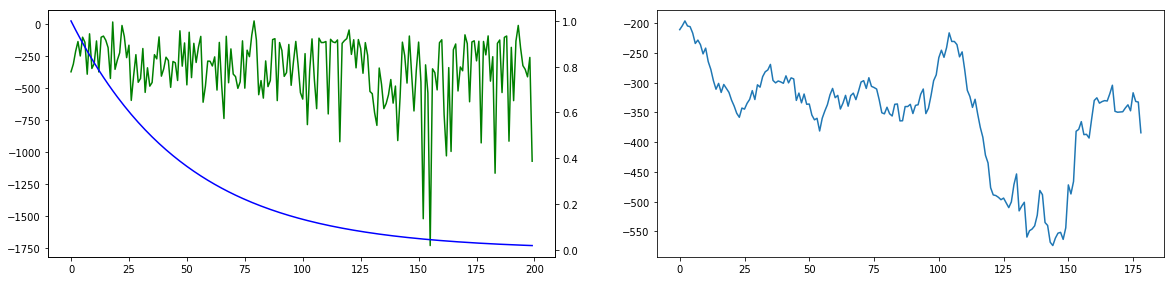

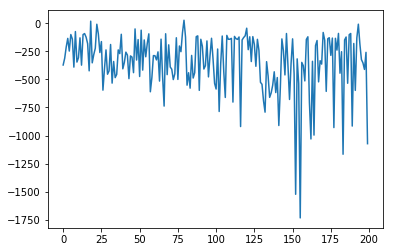

In [19]:
env = env_discrete

numObservation = env.observation_space.shape[0]
numActions = env.action_space.n
numHidden = 32
numHiddenLayer = 1 #Already has a hidden layer

modelFileName = "LunarLanderWeights.h5"

agent = rocketMan_V2(env, numObservation, numActions, numHidden, numHiddenLayer, modelFileName,
                    save=True, load=False)
starting_state = env.reset() # Getting things ready

num_episodes = 200 
max_steps = 2000

reward_array = np.ndarray(shape = (num_episodes, max_steps))
steps_array = np.ndarray(shape = (num_episodes))


rewardList = []
meanRewards = []
episodeList = []
for episode in range(num_episodes):
    step = 1
    reward_sum = 0
    
    # reseting the environment and getting the starting episode action. 
    current_state = env.reset().reshape(1, numObservation)
    chosen_action = agent.select_epsilon_greedy_action(current_state)    
    
# The main loop for a given episode ------------------------------
    done = False
    while done == False and step < max_steps:   # The problem is here:
            
        next_state, reward, done, info = env.step(chosen_action)
        next_state = next_state.reshape(1, numObservation)  # Tedious reshaping needed.
        
        agent.add_to_replay_buffer(chosen_action, current_state, next_state, reward, done)
        
        # Setting things up for the next iteration of the while loop 
        current_state = next_state
        chosen_action = agent.select_epsilon_greedy_action(current_state)
        
        step += 1
        reward_sum += reward
        
        if(episode == num_episodes-1):
            env.render()
            
    steps_array[episode] = step    
    
    # We
    agent.learn_from_m_random_transitions_in_replay_buffer(50)
    rewardList.append(reward_sum)
    episodeList.append(agent.epsilon)
    
    #agent.epsilon *= agent.epsilonDecay
    agent.updateEpsilon()
    
    clear_output(wait=True)
    
    if(episode > 20):
        meanRewards.append(np.mean(rewardList[-19:]))
    

    plt.figure(figsize=(20, 10))
    ax = plt.subplot(2,2,1)
    #ax.plot(range(episode+1), rewardList)
    ax2 = ax.twinx()
    ax.plot(range(episode+1), rewardList, 'g-')
    ax2.plot(range(episode+1), episodeList, 'b-')

    ax = plt.subplot(2,2,2)
    ax.plot(range(len(meanRewards)), meanRewards)
    plt.show()
    
    
    #Saving the trained model
agent.q_network.save_weights(modelFileName)
env.close()

plt.plot(range(num_episodes), rewardList)
plt.show()


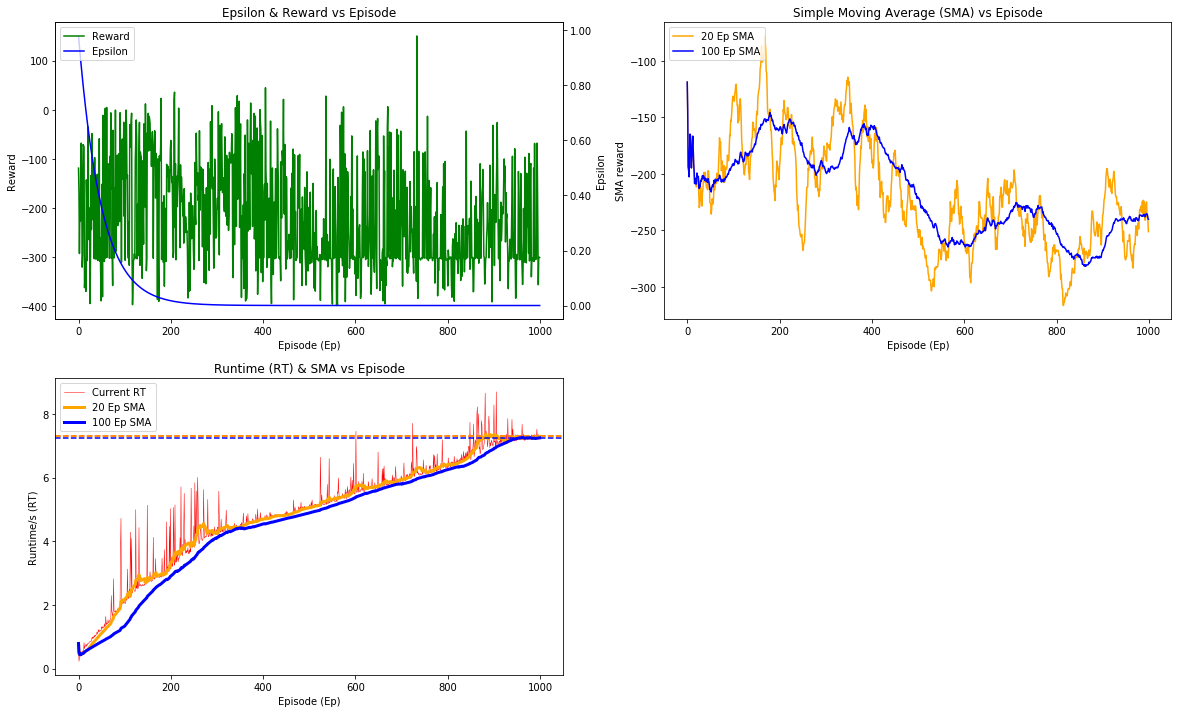

RT:  6251.589334639


In [7]:
numEpisodes = 1000 #added 1 so will render the last episode
minReward = -300 #If the sum reward drops below this, stop

from timeit import default_timer as timer
import os
from matplotlib.ticker import FormatStrFormatter

'''
modelFileName = 'trained_V6_weights_file.h5'

#Repeatablilty
seed = 32

#Loading the gym environment
env = gym.make('LunarLander-v2')

# Set seed for PRN generator of numpy, random module and gym env.
np.random.seed(seed)
random.seed(seed)
env.seed(seed)

numInput = env.observation_space.shape[0]
numActions = env.action_space.n

#Number of hidden neurons and layers0
numHidden = 128
numHiddenLayers = 1
'''

env = env_discrete

numObservation = env.observation_space.shape[0]
numActions = env.action_space.n
numHidden = 32
numHiddenLayer = 1 #Already has a hidden layer

modelFileName = "LunarLanderWeights.h5"

#Creating agent (rocketMan)
agent = rocketMan_V2(env, numObservation, numActions, numHidden, numHiddenLayer, modelFileName,
                    save=False, load=False)

#Information for plotting
rewardList = []
meanRewards = []
meanRewards1 = []
epsilonList = []
scores_window = deque(maxlen=100)
scores_window1 = deque(maxlen=20)

#These are getting a bit confusing, rename.
RTmean = []
RTwindow = deque(maxlen=20)
RTwindow1 = deque(maxlen=100)
meanRTWindow = []
meanRTWindow1 = []

#Every 'n' steps, render the lander
renderEvery = 100
saveRecordings = False #Do you want to save the file

avgEpisodeRT = 0 #The average runtime for each episode

max_steps = 2000

start = timer()
for episodeNum in range(numEpisodes):
    renderEpsiode = False #By default, do not render the episode
    
    if ((episodeNum % renderEvery) == 0) and (saveRecordings):
        renderEpsiode = True
        env = gym.wrappers.Monitor(env, 'recording/' + str(episodeNum) + '/', force=True) 
        
    # Get rid of epsilon after 300 episodes. After that point the agent has learned enough. 
    #if episodeNum > 300: 
    #    rocketManAgent.epsilon = 0
    
    
    state = env.reset()
    step = 0
    episodeReward = 0
    episodeStartTime = timer()
    
    current_state = env.reset().reshape(1, numObservation)
    chosen_action = agent.select_epsilon_greedy_action(current_state)   
    
    while True:            
        next_state, reward, done, info = env.step(chosen_action)
        next_state = next_state.reshape(1, numObservation)  # Tedious reshaping needed.
        
        agent.add_to_replay_buffer(chosen_action, current_state, next_state, reward, done)
        
        # Setting things up for the next iteration of the while loop 
        current_state = next_state
        chosen_action = agent.select_epsilon_greedy_action(current_state)
        
        step += 1
        episodeReward += reward
        
        
        if(episodeReward < minReward):
            done = True
            
        if(step > max_steps):
            done = True
        
        if done == True:
            agent.learn_from_m_random_transitions_in_replay_buffer(50)
            #rocketManAgent.train()
            
            #print("Test:", len(rocketManAgent.replay.getBuffer()))
            
            #Updating epsilon
            agent.updateEpsilon()
            
            rewardList.append(episodeReward)
            epsilonList.append(agent.epsilon)
            scores_window.append(episodeReward)
            scores_window1.append(episodeReward)
            
            meanRewards.append(np.mean(scores_window))
            meanRewards1.append(np.mean(scores_window1))
            
            episodeEndTime = timer()
            
            if not renderEpsiode:
                epRT = (episodeEndTime - episodeStartTime)
                RTmean.append(epRT)
                RTwindow.append(epRT)
                RTwindow1.append(epRT)
                meanRTWindow.append(np.mean(RTwindow))
                meanRTWindow1.append(np.mean(RTwindow1))
                    
            
            clear_output(wait=True)
            
            plt.figure(figsize=(20, 12))            
            plt.subplots_adjust(top=0.88)
            plt.tight_layout()
            
            ax = plt.subplot(2,2,1)
            ax2 = ax.twinx()
            ax.set_title("Epsilon & Reward vs Episode")
            ax.set_ylabel("Reward")
            ax2.set_ylabel("Epsilon")
            ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.set_xlabel("Episode (Ep)")
            lns1 = ax.plot(range(episodeNum+1), rewardList, 'g-', label="Reward")
            lns2 = ax2.plot(range(episodeNum+1), epsilonList, 'b-', label="Epsilon")
            
            lns = lns1+lns2
            labs = [l.get_label() for l in lns]
            ax2.legend(lns, labs, loc=2)

            ax = plt.subplot(2,2,2)
            ax.set_title("Simple Moving Average (SMA) vs Episode")
            ax.set_ylabel("SMA reward")
            ax.set_xlabel("Episode (Ep)")            
            ax.plot(range(len(meanRewards1)), meanRewards1, color='orange', label="20 Ep SMA")
            ax.plot(range(len(meanRewards)), meanRewards, color='blue', label="100 Ep SMA")
            plt.legend(loc=2)
            
            if(len(RTmean) > 0):
                ax = plt.subplot(2,2,3)   
                ax.set_title("Runtime (RT) & SMA vs Episode")
                ax.set_ylabel("Runtime/s (RT)")
                ax.set_xlabel("Episode (Ep)")
                
                ax.plot((range(len(RTmean))), RTmean, color='r', label="Current RT", linewidth=0.5)
                plt.axhline(y=RTmean[-1], color='r', linestyle='--')
                
                ax.plot((range(len(meanRTWindow))), meanRTWindow, color='orange', label="20 Ep SMA", linewidth=3.0)
                plt.axhline(y=meanRTWindow[-1], color='orange', linestyle='--')

                ax.plot((range(len(meanRTWindow1))), meanRTWindow1, color='blue', label="100 Ep SMA", linewidth=3.0)
                plt.axhline(y=meanRTWindow1[-1], color='blue', linestyle='--')
                            
                plt.legend(loc=2)
            plt.savefig('plotImages/' + str(episodeNum) + '.png')
            plt.show()                      
            
            #Resetting epsiode rewards
            
            env.close()
            
            
            #print("Epsiode RT: ", (episodeEndTime - episodeStartTime), " | Average: ", (avgEpisodeRT/(episodeNum+1)))
            break
    env.close()
end = timer()
            
            
#rocketManAgent.network.save_weights(modelFileName)

#Creating video
os.system("ffmpeg -f image2 -r 24 -i plotImages/%d.png -y -an recording/timelapse.mp4")

#Delete files in folder
import glob

files = glob.glob('plotImages/*')
for f in files:
    os.remove(f)

    
print("RT: ", (end - start))